In [4]:
# Necessary Imports
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from pymongo import MongoClient
from dotenv import load_dotenv
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from scipy.fft import fft
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import seaborn as sns
from generation import generate_gaze_points

# Load environment variables
load_dotenv()


True

In [1]:
key_width = 160 * 0.75

def generate_key_positions(win_width=2048, win_height=1152, key_width=160 * 0.75, key_height=160 * 0.75, horizontal_spacing=key_width * 0.25, vertical_spacing=200, num_points=100):
    top_row_y = win_height / 2 - vertical_spacing * 1.5
    middle_row_y = top_row_y - vertical_spacing
    bottom_row_y = middle_row_y - vertical_spacing

    row1_labels = ['Q', 'W', 'E', 'R', 'T', 'Y', 'U', 'I', 'O', 'P']
    row2_labels = ['A', 'S', 'D', 'F', 'G', 'H', 'J', 'K', 'L']
    row3_labels = ['Z', 'X', 'C', 'V', 'B', 'N', 'M']

    def calculate_start_x(num_keys):
        total_width = num_keys * key_width + (num_keys - 1) * horizontal_spacing
        return -total_width / 2 + key_width / 2

    def compute_key_positions(labels, start_x, y_pos):
        positions = []
        for i, label in enumerate(labels):
            x = start_x + i * (key_width + horizontal_spacing)
            positions.append((label, [x, y_pos]))
        return positions

    start_x_row1 = calculate_start_x(len(row1_labels))
    start_x_row2 = calculate_start_x(len(row2_labels))
    start_x_row3 = calculate_start_x(len(row3_labels))

    key_positions = {}
    for label, pos in compute_key_positions(row1_labels, start_x_row1, top_row_y):
        key_positions[label.upper()] = pos
    for label, pos in compute_key_positions(row2_labels, start_x_row2, middle_row_y):
        key_positions[label.upper()] = pos
    for label, pos in compute_key_positions(row3_labels, start_x_row3, bottom_row_y):
        key_positions[label.upper()] = pos

    key_positions['BOTAO_ACABAR'] = [0, bottom_row_y - vertical_spacing]

    return key_positions

positions = generate_key_positions()

Preprocessing real data...
Extracting features...
Training the classifier...
Epoch [1/10], Training Loss: 4.4550, Validation Loss: 1.2559
Epoch [2/10], Training Loss: 2.1978, Validation Loss: 0.6189
Epoch [3/10], Training Loss: 1.6447, Validation Loss: 0.4289
Epoch [4/10], Training Loss: 1.3898, Validation Loss: 0.3436
Epoch [5/10], Training Loss: 1.2324, Validation Loss: 0.3112
Epoch [6/10], Training Loss: 1.1206, Validation Loss: 0.2633
Epoch [7/10], Training Loss: 1.0312, Validation Loss: 0.2315
Epoch [8/10], Training Loss: 0.9579, Validation Loss: 0.1920
Epoch [9/10], Training Loss: 0.8980, Validation Loss: 0.1900
Epoch [10/10], Training Loss: 0.8510, Validation Loss: 0.1677


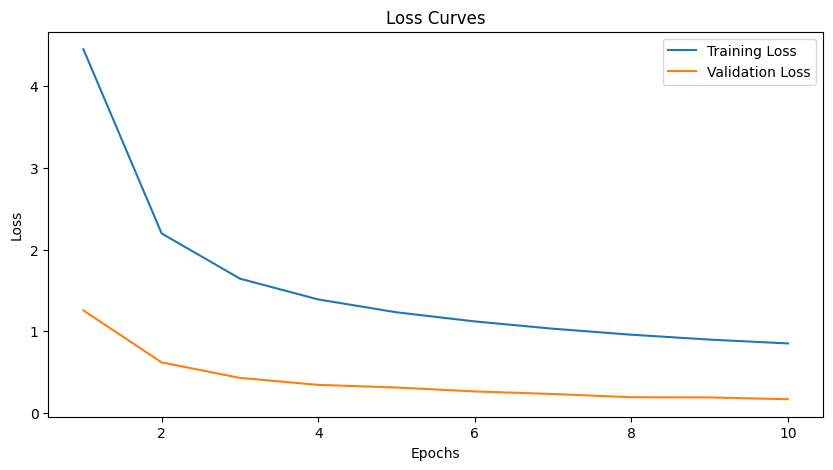

Validation Accuracy: 0.9467
Classification Report:
               precision    recall  f1-score   support

            A       0.85      0.96      0.90        46
        ABOUT       0.95      1.00      0.97        35
       ACCESS       1.00      1.00      1.00        39
          ADD       1.00      1.00      1.00        41
      ADDRESS       0.96      1.00      0.98        43
        AFTER       1.00      0.98      0.99        44
          ALL       0.95      1.00      0.97        38
         ALSO       1.00      1.00      1.00        37
           AM       0.65      0.55      0.60        31
     AMERICAN       1.00      1.00      1.00        35
           AN       0.71      0.77      0.74        44
          AND       1.00      1.00      1.00        45
          ANY       0.97      0.97      0.97        39
          ARE       0.97      0.82      0.89        40
         AREA       1.00      0.96      0.98        47
          ART       1.00      0.92      0.96        37
           AS

c:\Users\gugu1\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gugu1\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\gugu1\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

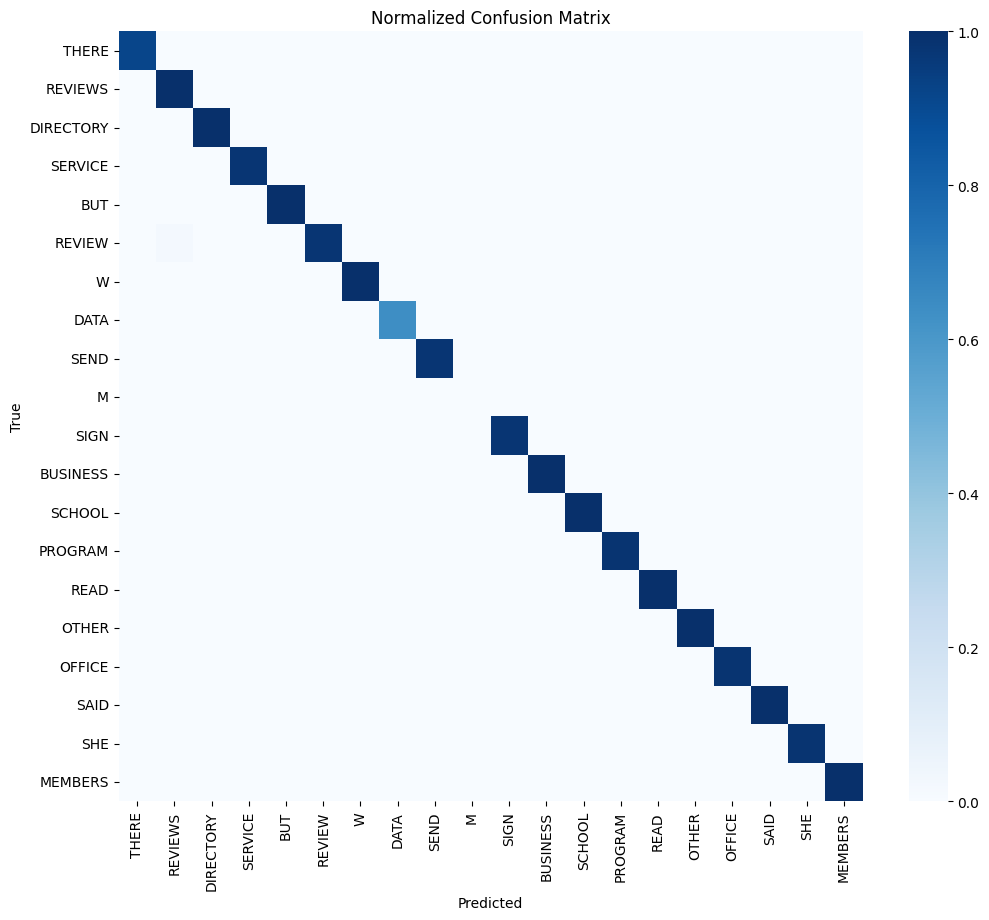

In [24]:
from sklearn.model_selection import train_test_split

with open('words.txt', 'r') as f:
    words_list = f.readlines()
words_list = [word.strip() for word in words_list]
words_list = words_list[:350]

num_synthetic_samples_per_word = 200
num_points = 129 
key_positions = positions  

synthetic_data = []
synthetic_labels = []
for word in words_list:
    for _ in range(num_synthetic_samples_per_word):
        gaze_points = generate_gaze_points(word.upper(), key_positions, num_points)
        gaze_points = np.array(gaze_points)
        synthetic_data.append(gaze_points)
        synthetic_labels.append(word.upper())

print("Preprocessing real data...")

def extract_features(gaze_points):
    x = gaze_points[:, 0]
    y = gaze_points[:, 1]
    
    features = np.concatenate((x, y))
    return features

print("Extracting features...")
synthetic_features = []
for gaze_points in synthetic_data:
    features = extract_features(gaze_points)
    synthetic_features.append(features)

label_encoder = LabelEncoder()
synthetic_labels_encoded = label_encoder.fit_transform(synthetic_labels)

X_train, X_eval, y_train, y_eval = train_test_split(synthetic_features, synthetic_labels_encoded, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_eval = torch.tensor(X_eval, dtype=torch.float32)
y_eval = torch.tensor(y_eval, dtype=torch.long)

class GazeDataset(Dataset):
    def __init__(self, features, labels):
        self.X = features
        self.y = labels
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = GazeDataset(X_train, y_train)
eval_dataset = GazeDataset(X_eval, y_eval)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)

import torch
import torch.nn as nn

class ConvClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ConvClassifier, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        
        self.fc1 = nn.Linear(128 * input_size, 256)
        self.relu4 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.relu5 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        B, L = x.shape  
        x = x.view(x.size(0), 1, -1)  # adiciona a dimensão de canal
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        
        x = x.view(B, -1) 
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu5(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        
        return x


input_size = X_train.shape[1]
num_classes = len(label_encoder.classes_)
model = ConvClassifier(input_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
training_loss = []
validation_loss = []

print("Training the classifier...")
for epoch in range(num_epochs):
    model.train()
    epoch_training_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_training_loss += loss.item()
    avg_training_loss = epoch_training_loss / len(train_loader)
    training_loss.append(avg_training_loss)

    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in eval_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            epoch_val_loss += loss.item()
    avg_val_loss = epoch_val_loss / len(eval_loader)
    validation_loss.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_training_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), training_loss, label='Training Loss')
plt.plot(range(1, num_epochs+1), validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()

model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for batch_X, batch_y in eval_loader:
        outputs = model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(batch_y.tolist())
        y_pred.extend(predicted.tolist())

accuracy = accuracy_score(y_true, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Normalized Confusion Matrix')
    plt.show()


top_n = 20  
class_counts = np.bincount(y_true)
top_n_classes_idx = np.argsort(class_counts)[-top_n:]
top_n_classes = label_encoder.inverse_transform(top_n_classes_idx)

cm_top_n = cm_norm[np.ix_(top_n_classes_idx, top_n_classes_idx)]

plot_confusion_matrix(cm_top_n, top_n_classes)

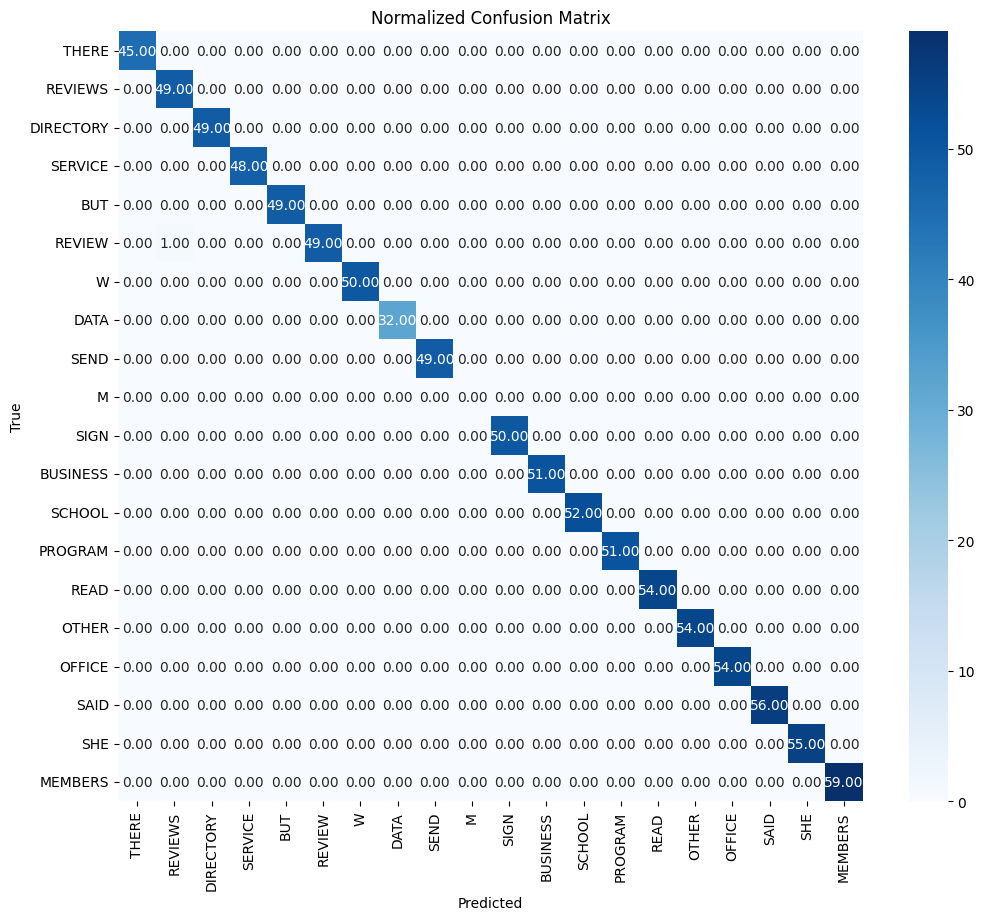

In [25]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Normalized Confusion Matrix')
    plt.show()


top_n = 20  
class_counts = np.bincount(y_true)
top_n_classes_idx = np.argsort(class_counts)[-top_n:]
top_n_classes = label_encoder.inverse_transform(top_n_classes_idx)

cm_top_n = cm[np.ix_(top_n_classes_idx, top_n_classes_idx)]

plot_confusion_matrix(cm_top_n, top_n_classes)